In [ ]:
# GET ENV DATA !
%env

In [ ]:
%pip install seaborn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

### DATA PREPROCESSING

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical #type: ignore

import pickle
X = np.vstack([
    pickle.load(open(os.path.join("/datasets/music3","images3_big_part1.pkl"), "rb")),
    pickle.load(open(os.path.join("/datasets/music3","images3_big_part2.pkl"), "rb")),
    pickle.load(open(os.path.join("/datasets/music3","images3_big_part3.pkl"), "rb")),
    pickle.load(open(os.path.join("/datasets/music3","images3_big_part4.pkl"), "rb"))])

target = pickle.load(open(os.path.join("/datasets/music3","target3_big.pkl"), "rb"))
y = target[:,1]
i_range = np.arange(y.shape[0])

X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(X, y, i_range, test_size=0.2, random_state=42, stratify=y)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], X_train.shape[3])

y_train_factorized = pd.factorize(y_train, sort=True)
y_test_factorized = pd.factorize(y_test, sort=True)

y_train = to_categorical(y_train_factorized[0])
y_test = to_categorical(y_test_factorized[0])

### MODEL

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

def lenet5():
    """Le modèle qui nous permet d'inférer le genre d'un fichier audio.

    Returns:
        keras.models.Sequential: Le modèle.
    """
    model = Sequential()
    model.add(BatchNormalization(input_shape=(84, 1292, 3), momentum=0.99))
    # CONV POOL 0
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 1
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 2
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # CONV POOL 3
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # DROPOUT AVANT LE FLATTEN
    model.add(Flatten())
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=512, activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=512, activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=256, activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=128, activation='relu'))
    model.add(BatchNormalization(momentum=0.99))
    model.add(Dense(units=128, activation='relu'))
    # OUTPUT LAYER
    model.add(Dense(units=21, activation = 'sigmoid'))
    
    return model

my_model = lenet5()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
my_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

checkpoint_path = 'mdl_wts.hdf5'
model_path = "mdl.keras"

mcp_save = ModelCheckpoint(
    checkpoint_path, 
    save_best_only=True, 
    monitor='val_categorical_accuracy', 
    mode='max')
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_categorical_accuracy', 
    factor=0.50, 
    patience=10, 
    verbose=1,
    mode='max')
tensor_board = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0, 
    write_graph=True, 
    write_images=True)
callbacks = [mcp_save, reduce_lr_loss, tensor_board]
my_model.summary()

### MODEL TRAINING

In [ ]:
BATCH_SIZE = 256

my_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE, 
    epochs=150,
    callbacks=callbacks)

### LOAD PREVIOUSLY WEIGHTED MODEL

In [9]:
my_model.load_weights(checkpoint_path)
model_path = "mdl.keras"
my_model.save(model_path)

y_pred = my_model.predict(X_test)

### MODEL PERFORMANCE

In [14]:
from sklearn.metrics import f1_score
y_pred_factorized = np.argmax(y_pred, axis=1)

loss, metric = my_model.evaluate(X_test, y_test, verbose=0)

print('loss is:', loss)
print('accu is:', metric)
print("f1_score is:",f1_score(y_test_factorized[0], y_pred_factorized, average="weighted"))

loss is: 2.112128496170044
accu is: 0.6928571462631226
f1_score is: 0.6933607896314501


[]

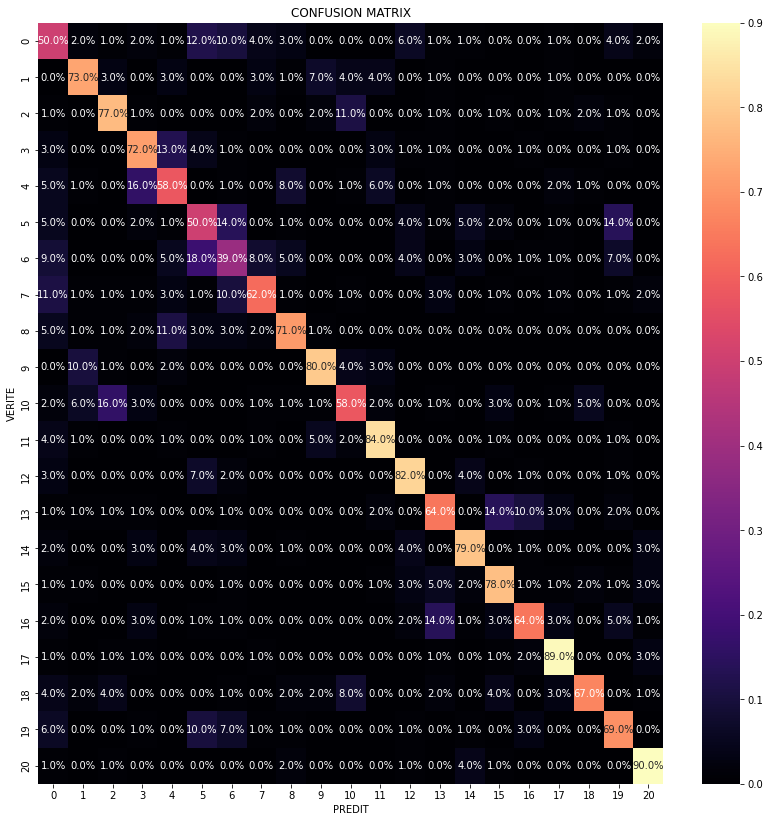

In [16]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_factorized[0], y_pred_factorized, normalize="true")
plt.figure(figsize=(14,14))
heat = sns.heatmap(conf, annot=True, cmap="magma", fmt = ".1%")
heat.set(xlabel="PREDIT", ylabel="VERITE", title="CONFUSION MATRIX")
plt.plot()

### MODEL PERFORMANCE EVALUATION ON A CASE BY CASE BASIS

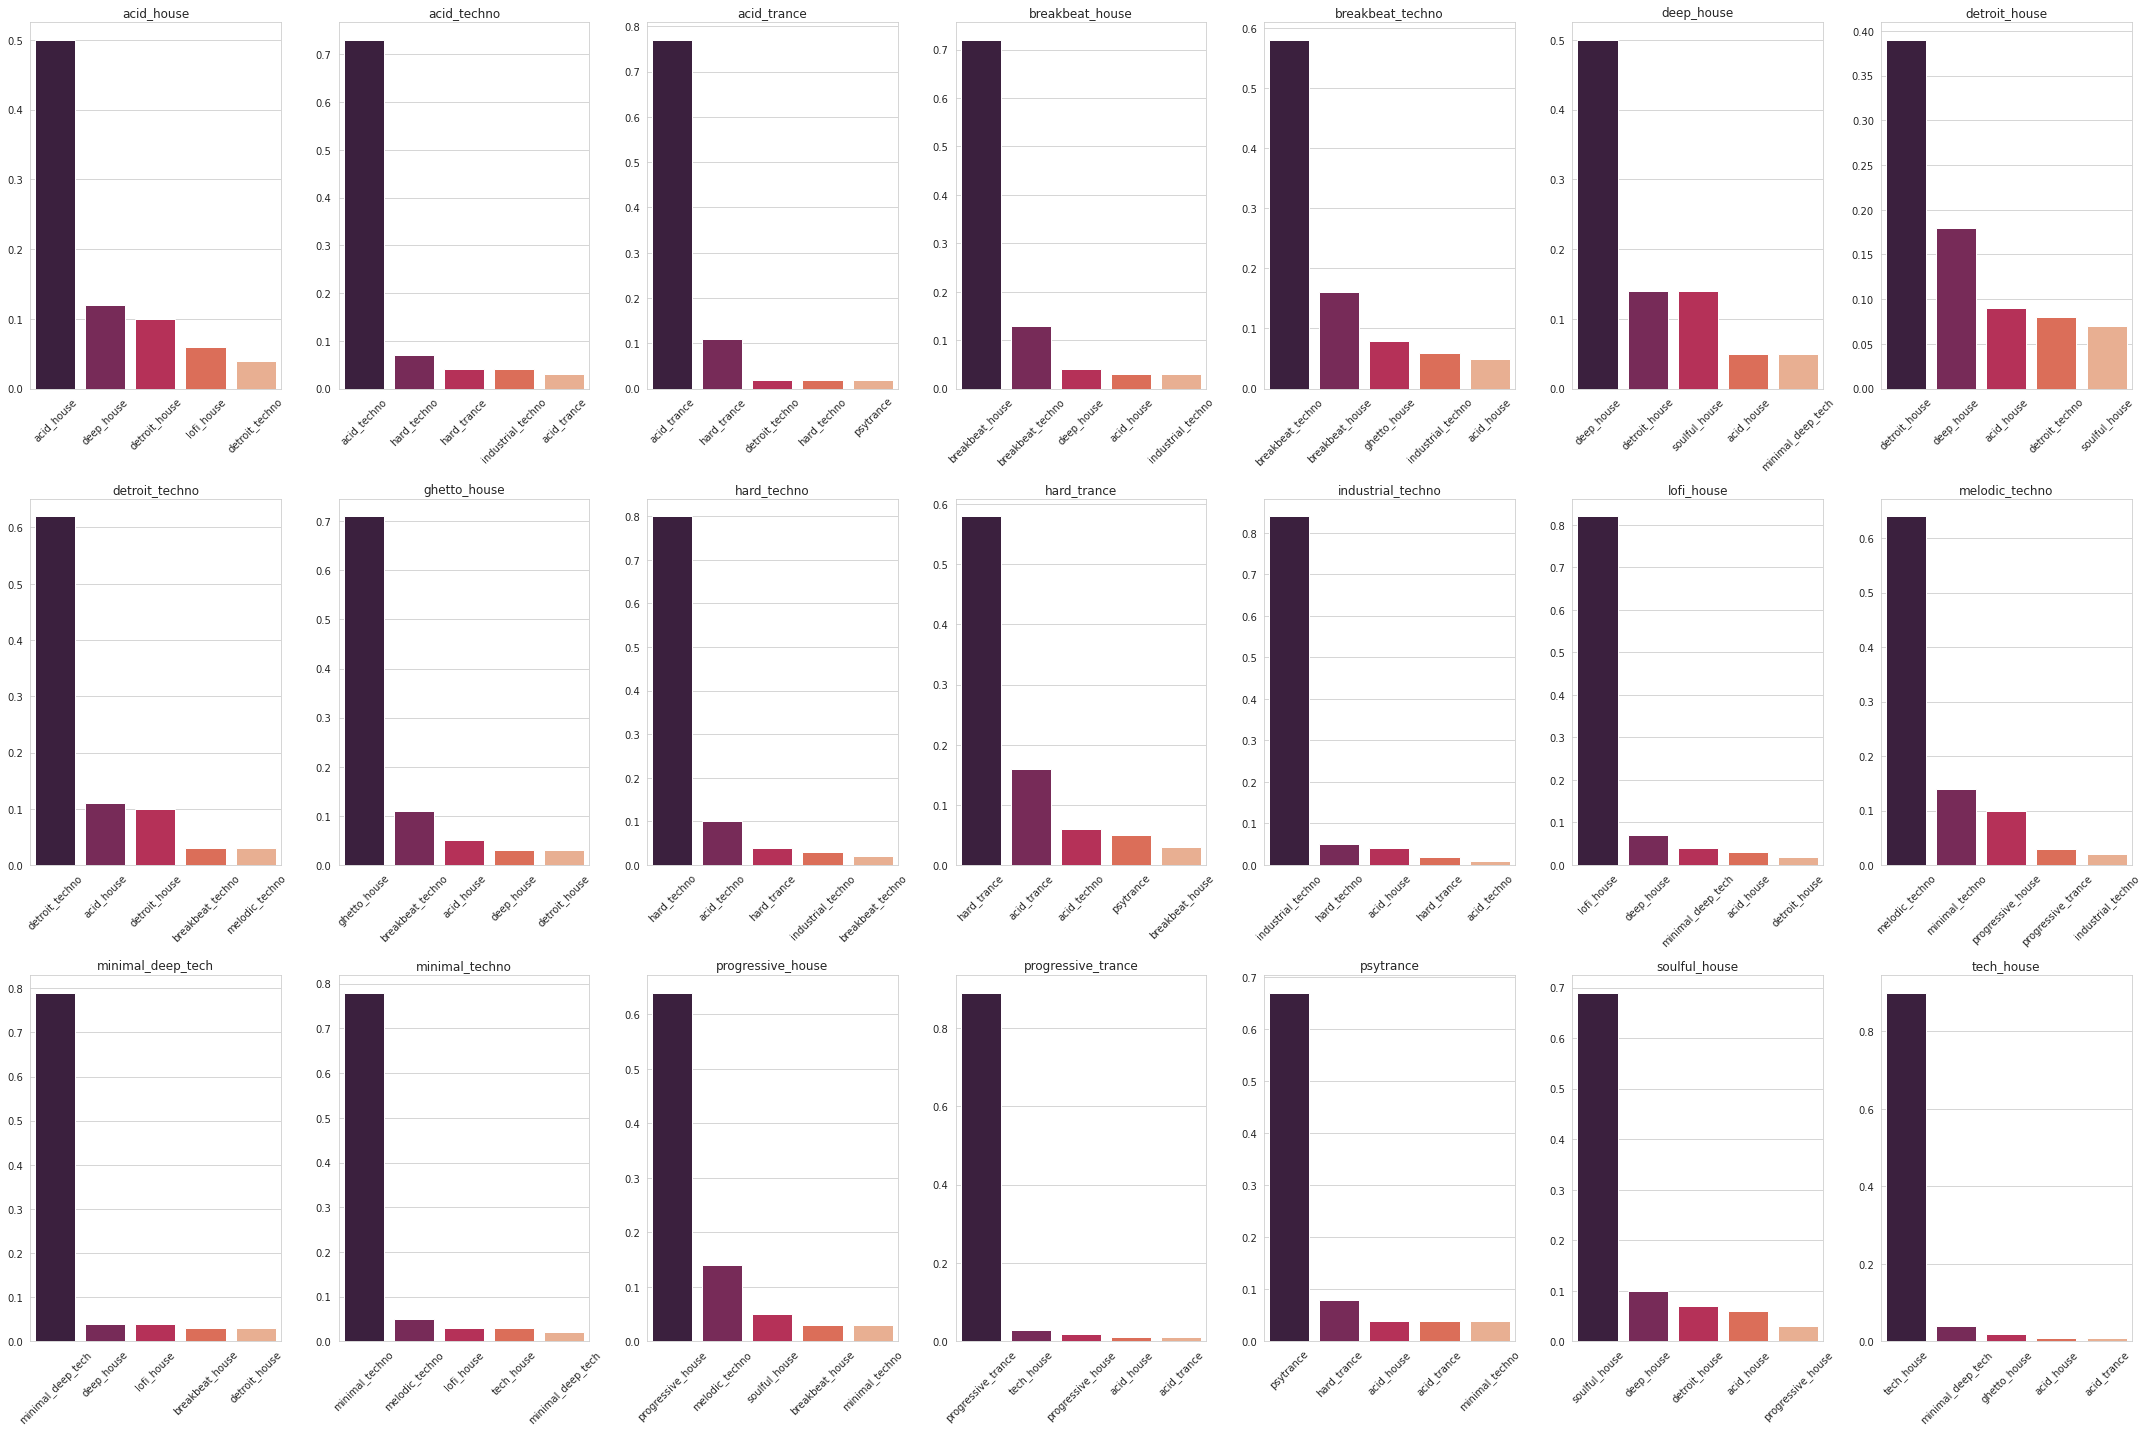

In [17]:
plt.figure(figsize=(30,20))
sns.set_style(style='whitegrid')
for i,genre in enumerate(conf):
    plt.subplot(3,7,i+1)
    style_line = sorted(list(zip(genre, y_test_factorized[1])), key = lambda x: x[0], reverse=True)[:5]
    sns.barplot(x = [x[1] for x in style_line], y = [x[0] for x in style_line], palette="rocket")
    plt.title(y_test_factorized[1][i])
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
